In [9]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

/package/anaconda3/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/package/anaconda3/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)


In [3]:
%%bash

# filter CA and DG high confidence binding sites based on padj

awk -v OFS="\t" '{if($9>15){printf "%s\t%.d\t%.d\tCA\n",$1,$2,$3}}' /home/ferrari/ferrari/PhD_project/reference_datasets/FOXG1_project/Foxg1_ChIP-Seq_AdultHippo_6w/output_snakepipes/MACS2/CA1-1_FOXG1_mm_i69.filtered.BAM_peaks.narrowPeak > INTERMEDIATE_FILES/CA1-1_FOXG1_mm_i69.filtered.BAM_peaks.filtered.bed

awk -v OFS="\t" '{if($9>15){printf "%s\t%.d\t%.d\tDG\n",$1,$2,$3}}' /home/ferrari/ferrari/PhD_project/reference_datasets/FOXG1_project/Foxg1_ChIP-Seq_AdultHippo_6w/output_snakepipes/MACS2/DG_FOXG1_mm_i68.filtered.BAM_peaks.narrowPeak > INTERMEDIATE_FILES/DG_FOXG1_mm_i68.filtered.BAM_peaks.filtered.bed



In [5]:
%%bash

# create consensus set
cat INTERMEDIATE_FILES/CA1-1_FOXG1_mm_i69.filtered.BAM_peaks.filtered.bed INTERMEDIATE_FILES/DG_FOXG1_mm_i68.filtered.BAM_peaks.filtered.bed | bedtools sort | bedtools merge -c 4 -o distinct > INTERMEDIATE_FILES/consensus_DG-CA_filtered.bed

# create intersect set
awk '{if($4 == "CA,DG"){print $0}}' INTERMEDIATE_FILES/consensus_DG-CA_filtered.bed > INTERMEDIATE_FILES/intersect_CA-DG.filtered.bed



In [6]:
%%bash

## Annotate consensus Peaks using Homer

source activate Homer

annotatePeaks.pl INTERMEDIATE_FILES/consensus_DG-CA_filtered.bed mm10 \
-gtf /home/ferrari/ferrari/my_repository/annotations_gencode/mouse/M18/annotation_snakePipes/gencode.vM18.annotation.sorted.gtf > INTERMEDIATE_FILES/Homer_PeaksAnnotation_CA-DG_consensus.tsv




	Peak file = INTERMEDIATE_FILES/consensus_DG-CA_filtered.bed
	Genome = mm10
	Organism = mouse
	Custom annotation GTF file: /home/ferrari/ferrari/my_repository/annotations_gencode/mouse/M18/annotation_snakePipes/gencode.vM18.annotation.sorted.gtf (using transcript_id)
	Peak/BED file conversion summary:
		BED/Header formatted lines: 35255
		peakfile formatted lines: 0
		Duplicated Peak IDs: 35252

	Peak File Statistics:
		Total Peaks: 35255
		Redundant Peak IDs: 0
		Peaks lacking information: 0 (need at least 5 columns per peak)
		Peaks with misformatted coordinates: 0 (should be integer)
		Peaks with misformatted strand: 0 (should be either +/- or 0/1)

	Peak file looks good!

	Reading Positions...
	-----------------------
	Finding Closest TSS...
	Processing custom annotation file...
	Features that will be considered:
		exon

	807591 lines contained useful feature information
	Features that will be considered:
		exon

	807591 lines contained useful feature information
	Prioritizing Ann

In [7]:
%%bash

# get coverage

multiBigwigSummary BED-file -b /home/ferrari/ferrari/PhD_project/reference_datasets/FOXG1_project/Foxg1_ChIP-Seq_AdultHippo_6w/output_snakepipes/bamCoverage/CA1-1_FOXG1_mm_i69.filtered.seq_depth_norm.bw \
/home/ferrari/ferrari/PhD_project/reference_datasets/FOXG1_project/Foxg1_ChIP-Seq_AdultHippo_6w/output_snakepipes/bamCoverage/DG_FOXG1_mm_i68.filtered.seq_depth_norm.bw \
-o INTERMEDIATE_FILES/CA-DG_consensus.mat.gz --BED INTERMEDIATE_FILES/consensus_DG-CA_filtered.bed -p 20 --outRawCounts INTERMEDIATE_FILES/CA-DG_consensus.txt



Number of bins found: 35255


/home/ferrari/.local/lib/python3.6/site-packages/seaborn/distributions.py:218: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  color=hist_color, **hist_kws)
/home/ferrari/.local/lib/python3.6/site-packages/seaborn/distributions.py:218: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  color=hist_color, **hist_kws)


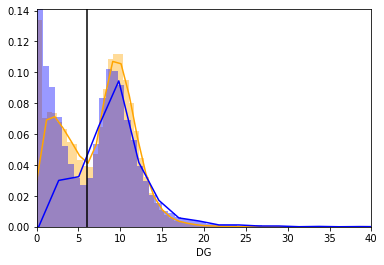

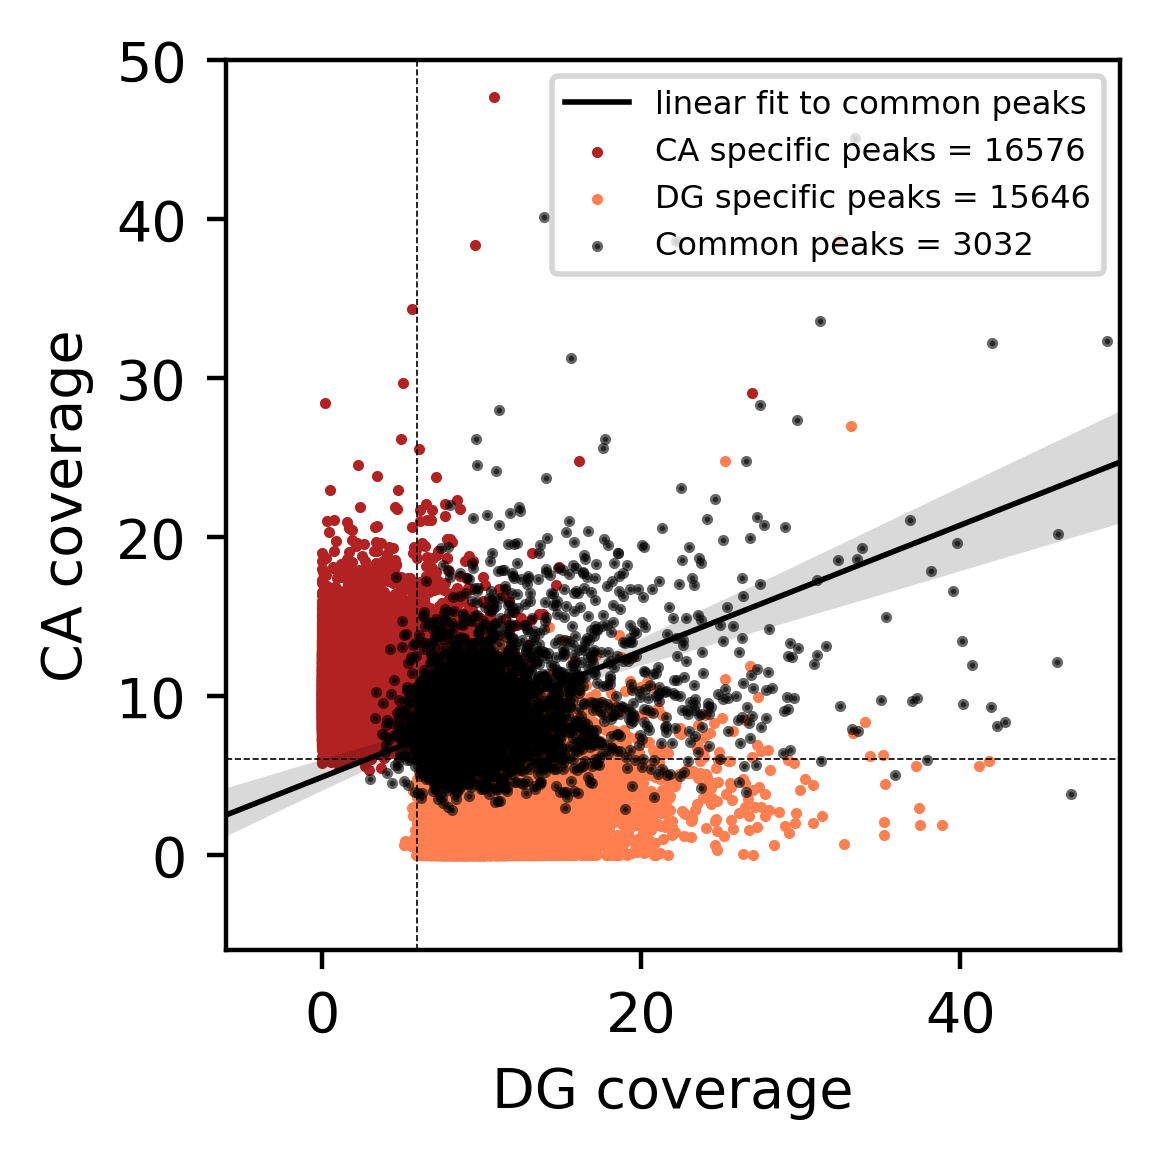

In [11]:
dg_ca = pd.read_csv("INTERMEDIATE_FILES/consensus_DG-CA_filtered.bed",sep="\t", header=0, names=["chr","start","end","sample"])
dg_ca.index = ["{}_{}_{}".format(dg_ca.chr[i],dg_ca.start[i],dg_ca.end[i]) for i in dg_ca.index]

cov = pd.read_csv("INTERMEDIATE_FILES/CA-DG_consensus.txt",sep="\t", header=0, names=["chr","start","end","CA","DG"])
cov.index = ["{}_{}_{}".format(cov.chr[i],cov.start[i],cov.end[i]) for i in cov.index]

cov.head()
sns.distplot(cov.CA.dropna(),bins=200, color="orange")
sns.distplot(cov.DG.dropna(),bins=400, color="b")
plt.axvline(6, color='k')
plt.xlim((0,40))

fig,ax = plt.subplots(dpi=400, figsize=(3,3))

#ax.scatter(cov.CA,cov.DG,s=1)
intersec = dg_ca.loc[dg_ca["sample"] == "CA,DG"].index
ca = dg_ca.loc[dg_ca["sample"] == "CA"].index
dg = dg_ca.loc[dg_ca["sample"] == "DG"].index

ax.scatter(cov.DG.loc[ca],cov.CA.loc[ca],s=1, label="CA specific peaks = {}".format(len(cov.CA.loc[ca])), color = "firebrick", alpha=1)
ax.scatter(cov.DG.loc[dg],cov.CA.loc[dg],s=1, label="DG specific peaks = {}".format(len(cov.DG.loc[dg])), color = "coral",alpha=1)

ax.scatter(cov.DG.loc[intersec],cov.CA.loc[intersec],s=1,label="Common peaks = {}".format(len(cov.DG.loc[intersec])), color = "k",alpha=0.6)

ax.set_xlim((-6,50))
ax.set_ylim((-6,50))

sns.regplot(cov.DG.loc[intersec],cov.CA.loc[intersec], scatter=False, line_kws={"linewidth":1,"color":"k"}, label = "linear fit to common peaks")
ax.axhline(6,color="k",linestyle="--",linewidth=0.3)
ax.axvline(6,color="k",linestyle="--",linewidth=0.3)
ax.set_xlabel("DG coverage")
ax.set_ylabel("CA coverage")

plt.legend(fontsize="xx-small")

plt.tight_layout()

plt.savefig("FIGURES/coverage_peaks_filtered.png")

In [12]:
%%bash

### all peaks

module load deeptools

computeMatrix reference-point -S /home/ferrari/ferrari/PhD_project/reference_datasets/FOXG1_project/Foxg1_ChIP-Seq_AdultHippo_6w/output_snakepipes/bamCoverage/CA1-1_FOXG1_mm_i69.filtered.seq_depth_norm.bw \
/home/ferrari/ferrari/PhD_project/reference_datasets/FOXG1_project/Foxg1_ChIP-Seq_AdultHippo_6w/output_snakepipes/bamCoverage/DG_FOXG1_mm_i68.filtered.seq_depth_norm.bw \
-R INTERMEDIATE_FILES/consensus_DG-CA_filtered.bed -o INTERMEDIATE_FILES/computeMatrix_CA-DG_consensus.mat.gz \
--referencePoint center -b 1000 -a 1000 --missingDataAsZero \
-bl /home/ferrari/ferrari/my_repository/blacklist_ChIP-Seq/GRCm38_General_readAttractingRegions.UseThisOne_DKFZ.bed \
--smartLabels -p 20 

Skipping 11:109011642-109012085, due to being absent in the computeMatrix output.
Skipping 16:35981581-35981912, due to being absent in the computeMatrix output.
Skipping 17:39846373-39848330, due to being absent in the computeMatrix output.
Skipping 3:5860310-5860816, due to being absent in the computeMatrix output.
Skipping 5:146260960-146261355, due to being absent in the computeMatrix output.
Skipping 9:123461833-123462178, due to being absent in the computeMatrix output.


In [13]:
%%bash

module load deeptools
### create clustered heatmap on consensus to identify region-specific and common peaks
plotHeatmap -m INTERMEDIATE_FILES/computeMatrix_CA-DG_consensus.mat.gz -o FIGURES/clustHeatmap_FOXG1_CA-DG_consensus.png \
--averageTypeSummaryPlot median --kmeans 5 --colorList "white,firebrick" "white,coral" \
--outFileSortedRegions INTERMEDIATE_FILES/clusters_DG-CA_consensus.tsv --samplesLabel CA DG \
--refPointLabel center



In [15]:
%%bash

### TSS only

extract_from_gtf.py -o INTERMEDIATE_FILES/ -f TSS -a_tss 1000 -b_tss 1000 \
-w gene -prot_cod /home/ferrari/ferrari/my_repository/annotations_gencode/mouse/M18/annotation_snakePipes/gencode.vM18.annotation.sorted.gtf

Namespace(AFTER_GENE=0, AFTER_TES=500, AFTER_TSS=1000, BEFORE_GENE=0, BEFORE_TES=500, BEFORE_TSS=1000, FEATURE=['TSS'], PROTEIN_CODING=True, from_what='gene', gtf_file='/home/ferrari/ferrari/my_repository/annotations_gencode/mouse/M18/annotation_snakePipes/gencode.vM18.annotation.sorted.gtf', out_dir='INTERMEDIATE_FILES/', verbose=False)


In [24]:
%%bash

grep -v "^MT" INTERMEDIATE_FILES/TSS.bed > INTERMEDIATE_FILES/TSS_noMT.bed

In [25]:
%%bash

### all peaks

module load deeptools

computeMatrix reference-point -S /home/ferrari/ferrari/PhD_project/reference_datasets/FOXG1_project/Foxg1_ChIP-Seq_AdultHippo_6w/output_snakepipes/bamCoverage/CA1-1_FOXG1_mm_i69.filtered.seq_depth_norm.bw \
/home/ferrari/ferrari/PhD_project/reference_datasets/FOXG1_project/Foxg1_ChIP-Seq_AdultHippo_6w/output_snakepipes/bamCoverage/DG_FOXG1_mm_i68.filtered.seq_depth_norm.bw \
-R INTERMEDIATE_FILES/TSS_noMT.bed -o INTERMEDIATE_FILES/computeMatrix_CA-DG_TSSProtCod.mat.gz \
--referencePoint center -b 2000 -a 2000 --missingDataAsZero \
-bl /home/ferrari/ferrari/my_repository/blacklist_ChIP-Seq/GRCm38_General_readAttractingRegions.UseThisOne_DKFZ.bed \
--smartLabels -p 20 

Skipping ENSMUSG00000075014.1, due to being absent in the computeMatrix output.
Skipping ENSMUSG00000041827.15, due to being absent in the computeMatrix output.
Skipping ENSMUSG00000091028.1, due to being absent in the computeMatrix output.
Skipping ENSMUSG00000096385.7, due to being absent in the computeMatrix output.
Skipping ENSMUSG00000096519.1, due to being absent in the computeMatrix output.
Skipping ENSMUSG00000074564.3, due to being absent in the computeMatrix output.
Skipping ENSMUSG00000095547.1, due to being absent in the computeMatrix output.
Skipping ENSMUSG00000095186.1, due to being absent in the computeMatrix output.
Skipping ENSMUSG00000095891.7, due to being absent in the computeMatrix output.
Skipping ENSMUSG00000096736.1, due to being absent in the computeMatrix output.
Skipping ENSMUSG00000096201.1, due to being absent in the computeMatrix output.
Skipping ENSMUSG00000075046.7, due to being absent in the computeMatrix output.
Skipping ENSMUSG00000023764.18, due to 

In [28]:
%%bash

module load deeptools
### create clustered heatmap on consensus to identify region-specific and common peaks
plotHeatmap -m INTERMEDIATE_FILES/computeMatrix_CA-DG_TSSProtCod.mat.gz -o FIGURES/clustHeatmap_FOXG1_CA-DG_TSSProtCod.png \
--averageTypeSummaryPlot mean --kmeans 5 --colorList "white,firebrick" "white,coral" \
--outFileSortedRegions INTERMEDIATE_FILES/clusters_DG-CA_TSSProtCod.tsv --samplesLabel CA DG \
--refPointLabel TSS